In [4]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

In [8]:
image_path = "test-set/img1.png"
image = Image.open(image_path).resize((1080, 1080))

# convert image to RGB
image = image.convert('RGB')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

True Positives: 175018
False Positives: 12600
True Negatives: 963696
False Negatives: 15086


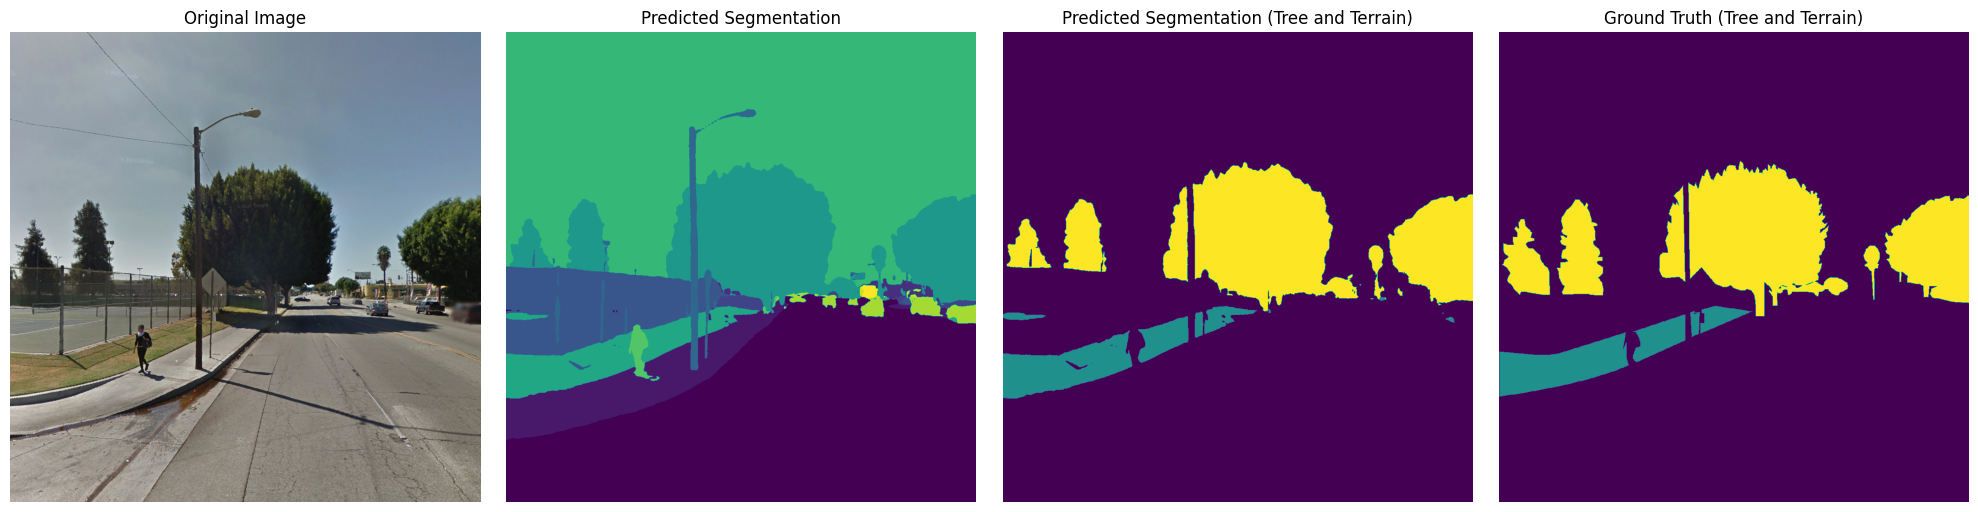

In [47]:
# Get predicted semantic segmentation
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)
pred_seg = upsampled_logits.argmax(dim=1)[0]

# Load ground truth segmentation mask
gt_path = "test-set/label1.png"
gt_mask = Image.open(gt_path).resize((1080, 1080))
gt_mask = np.array(gt_mask)


#convert 9->2 and 8->1, all else becomes 0
pred_converted_mask = np.zeros_like(pred_seg)

# Convert values: 9 (terrain) ->2, 8 (tree) ->1, all else 0
pred_converted_mask[pred_seg == 9] = 1
pred_converted_mask[pred_seg == 8] = 2


# Calculate confusion matrix metrics for both classes
tp = np.sum((pred_converted_mask == gt_mask) & (gt_mask != 0))  # True positives
fp = np.sum((pred_converted_mask != gt_mask) & (pred_converted_mask != 0))  # False positives 
tn = np.sum((pred_converted_mask == gt_mask) & (gt_mask == 0))  # True negatives
fn = np.sum((pred_converted_mask == 0) & (gt_mask != 0))  # False negatives

print(f"True Positives: {tp}")
print(f"False Positives: {fp}") 
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")




# Display original image, prediction and ground truth
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')


plt.subplot(1,4,2)
plt.imshow(pred_seg.cpu().numpy())
plt.title('Predicted Segmentation')
plt.axis('off')


plt.subplot(1,4,3)
plt.imshow(pred_converted_mask)
plt.title('Predicted Segmentation (Tree and Terrain)')
plt.axis('off')


plt.subplot(1,4,4)
plt.imshow(gt_mask)
plt.title('Ground Truth (Tree and Terrain)')
plt.axis('off')

plt.tight_layout()
plt.show()